##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Binary Classification with MobileNetV2
In this tutorial, you will learn how to conduct a Binary classification using transfer learning on MobileNetV2 to classify images of daisies and dandelions.

For this notebook we will be using the Daisies and Dandelions dataset which can be found [here](https://public.roboflow.com/classification/flowers_classification/1). This dataset is a collection of 1821 images images in 2 different classes. This tutorial is based on Tensorflow's [Transfer Learning on MobileNetV2 notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train MobileNetV2 On a Custom Dataset](blog.roboflow.com/how-to-train-mobilenetv2-on-a-custom-dataset/) concurrently.

### Steps Covered in this Tutorial

* Download data using Roboflow and Convert it into a Tensorflow ImageFolder Format 
* Construct the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
* Train & Evaluate the model
* Fine Tune the model to increase accuracy after convergence

### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

### Data download

We'll download our dataset from Roboflow. To download the dataset, use the "**Folder Structure**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

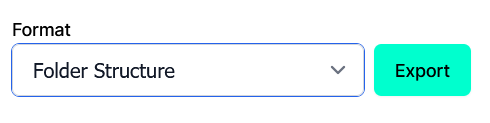


In [4]:
!curl -L "https://app.roboflow.com/ds/2hyNSrJMyC?key=5tTcCMOVW8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0   1664      0 --:--:-- --:--:-- --:--:--  1661
100 6942k  100 6942k    0     0  5766k      0  0:00:01  0:00:01 --:--:-- 5766k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: train/
   creating: train/boa/
 extracting: train/boa/IMG_0123_JPG.rf.77a2048857e0664a879dc716ec29a65c.jpg  
 extracting: train/boa/IMG_0123_JPG.rf.bd9b6139eb83911babe3db2b5c2f0f7b.jpg  
 extracting: train/boa/IMG_0123_JPG.rf.e997e4f8c549fe645dcebec0b097334c.jpg  
 extracting: train/boa/IMG_0125_JPG.rf.198b47d697f3f9d13550cb171ca7d674.jpg  
 extracting: train/boa/IMG_0125_JPG.rf.98974d20ccaf6e1cbc04049d5801037c.jpg  
 extracting: train/boa/IMG_0125_JPG.rf.e8dd334a185a7bf0989f856651609f24.jpg  
 extracting: train/boa/IMG_0127_JPG.rf.0c625ddfdc9f5b69fa50b57198ca3040.j

We need to turn this dataset into a Tensorflow Dataset format. Fortunately, Tensorflow provides the ImageFolder dataset structure which is compatible with the format we downloaded the data in. 

We will then use the builder to build the raw versions of our train, test, and validation data.

In [5]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
# raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=148,
    splits={
        'train': 129,
        'valid': 19,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



Show images and labels from the training set:

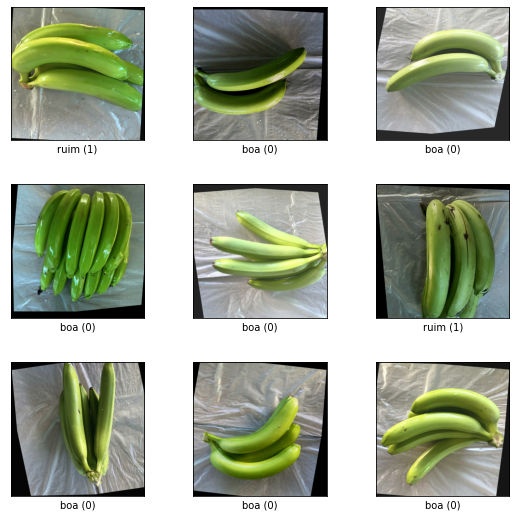

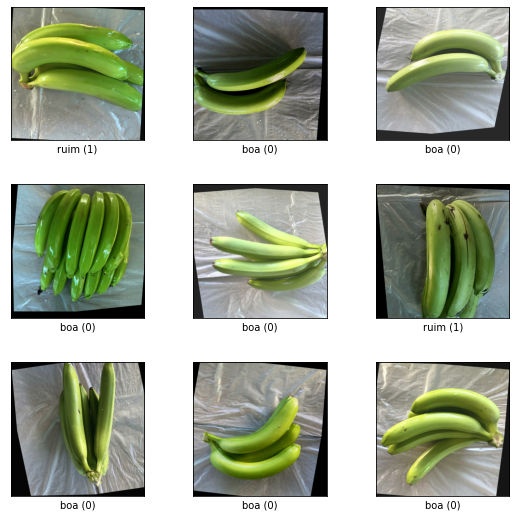

In [6]:
tfds.show_examples(raw_train, builder.info)

### Format the Data

We can use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [7]:
IMG_SIZE = 640 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [8]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)

Now shuffle and batch the data.

In [9]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

Inspect a batch of data:

In [11]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([64, 640, 640, 3])

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [26]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [27]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 20, 20, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [28]:
base_model.trainable = False

In [29]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 320, 320, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [31]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [32]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [35]:
len(model.trainable_variables)

2

### Train the model

After training for 20 epochs, you should see ~90%+ accuracy.


In [36]:
initial_epochs = 830
validation_steps=830

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

  1/830 [..............................] - ETA: 18:58 - loss: 0.6547 - accuracy: 0.6316WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 830 batches). You may need to use the repeat() function when building your dataset.


830/830 [==============================] - 1s 31us/step - loss: 0.6547 - accuracy: 0.6316


In [37]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.63


In [39]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=[cp_callback])

Epoch 1/830
2/3 [===================>..........] - ETA: 0s - loss: 0.6422 - accuracy: 0.6562
Epoch 1: saving model to training_1/cp.ckpt
3/3 [==============================] - 4s 581ms/step - loss: 0.6444 - accuracy: 0.6512 - val_loss: 0.6477 - val_accuracy: 0.6316
Epoch 2/830
2/3 [===================>..........] - ETA: 0s - loss: 0.6395 - accuracy: 0.6484
Epoch 2: saving model to training_1/cp.ckpt
3/3 [==============================] - 2s 561ms/step - loss: 0.6388 - accuracy: 0.6512 - val_loss: 0.6417 - val_accuracy: 0.6316
Epoch 3/830
2/3 [===================>..........] - ETA: 0s - loss: 0.6330 - accuracy: 0.6484
Epoch 3: saving model to training_1/cp.ckpt
3/3 [==============================] - 2s 566ms/step - loss: 0.6318 - accuracy: 0.6512 - val_loss: 0.6382 - val_accuracy: 0.6316
Epoch 4/830
2/3 [===================>..........] - ETA: 0s - loss: 0.6255 - accuracy: 0.6562
Epoch 4: saving model to training_1/cp.ckpt
3/3 [==============================] - 2s 563ms/step - loss: 0.62

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

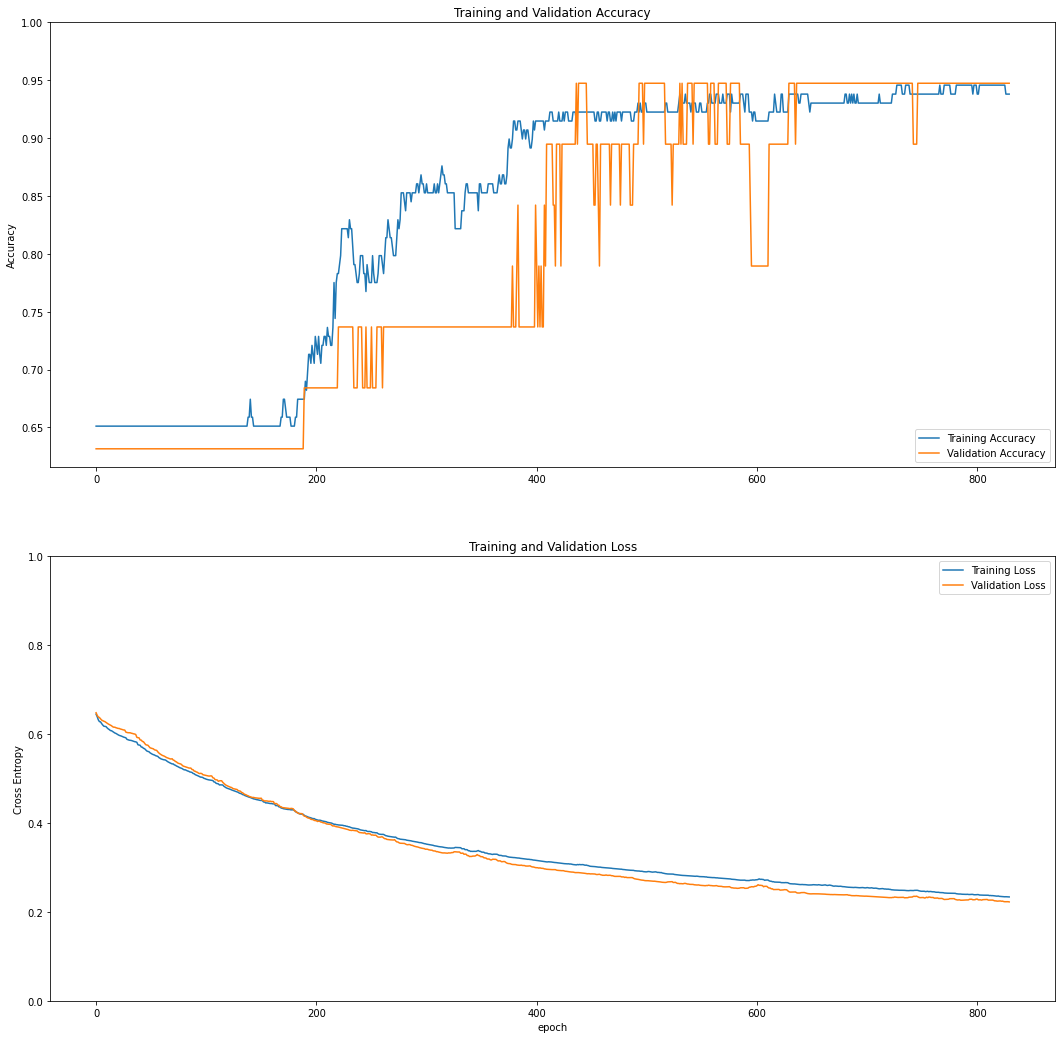

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Saving

In [42]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [43]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.8.0


In [44]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [46]:
# my_model directory
%ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
%ls saved_model/my_model

my_model/
assets/  keras_metadata.pb  saved_model.pb  variables/


In [47]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
!mkdir /content/drive/MyDrive/BananaStepps/model

In [50]:
!cp -r saved_model /content/drive/MyDrive/BananaStepps/model

In [52]:
!zip -r modelo.zip saved_model/my_model/ 

  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 91%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 76%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 96%)


In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
# plt.imshow(np.squeeze(image))
# plt.title("Dandelion" if model.predict(image) > 0 else "Daisy")
print(model.predict(image))

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

Compile the model using a much lower learning rate.

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [30]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [32]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 1000/1100
3/3 [==============================] - 2s 462ms/step - loss: 0.1403 - accuracy: 0.9457 - val_loss: 0.2441 - val_accuracy: 0.7895
Epoch 1001/1100
3/3 [==============================] - 2s 456ms/step - loss: 0.1350 - accuracy: 0.9535 - val_loss: 0.2427 - val_accuracy: 0.7895
Epoch 1002/1100
3/3 [==============================] - 2s 433ms/step - loss: 0.1301 - accuracy: 0.9535 - val_loss: 0.2441 - val_accuracy: 0.7895
Epoch 1003/1100
3/3 [==============================] - 2s 437ms/step - loss: 0.1176 - accuracy: 0.9535 - val_loss: 0.2460 - val_accuracy: 0.7368
Epoch 1004/1100
3/3 [==============================] - 2s 435ms/step - loss: 0.1157 - accuracy: 0.9535 - val_loss: 0.2469 - val_accuracy: 0.7368
Epoch 1005/1100
3/3 [==============================] - 2s 435ms/step - loss: 0.1107 - accuracy: 0.9535 - val_loss: 0.2476 - val_accuracy: 0.7368
Epoch 1006/1100
3/3 [==============================] - 2s 433ms/step - loss: 0.1037 - accuracy: 0.9535 - val_loss: 0.2479 - val_ac

KeyboardInterrupt: ignored

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

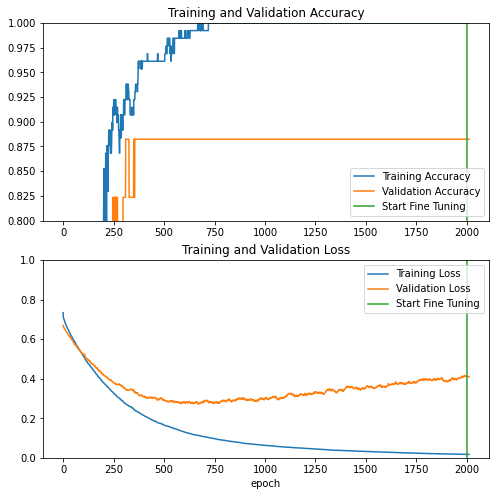

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Infer on a Sample Image

In [33]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
# plt.imshow(np.squeeze(image))
# plt.title("Dandelion" if model.predict(image) > 0 else "Daisy")
print(model.predict(image))

[[3.1946335]]


## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.
